In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
warnings.filterwarnings('ignore')
from sklearn import metrics

In [ ]:
data_DDR = 'GAE-128-16-new.csv'
df_ddr = pd.read_csv(data_DDR)

## KMeans Clustering

In [ ]:
def load_data(df):
  df2 = df.copy()
  y = df2['Unnamed: 0']
  cols = df2.columns
  ms = MinMaxScaler()
  X = ms.fit_transform(df2)
  X = pd.DataFrame(X, columns=[cols])
  return df2,y,X

def k_means_elbow_method(X,title):
  cs = []
  for i in range(1, 50):
      kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
      kmeans.fit(X)
      cs.append(kmeans.inertia_)
  plt.plot(range(1, 50), cs)
  plt.title('The Elbow Method '+title)
  plt.xlabel('Number of clusters')
  plt.ylabel('CS')
  plt.show()

def k_means_clustering(nclusters,X):
  kmeans = KMeans(n_clusters=nclusters, random_state=0) 
  kmeans.fit(X)
  kmeans.cluster_centers_
  print(kmeans.inertia_)
  return kmeans.labels_

def make_df(labels,y,name):
  df = pd.DataFrame({'node-value':y, 'cluster-label':labels})
  #df['drug'] = df2['nodes']
  df = df.sort_values('cluster-label')
  fileName = 'data/HC-128-16' + name
  df.to_csv(fileName)
  return df

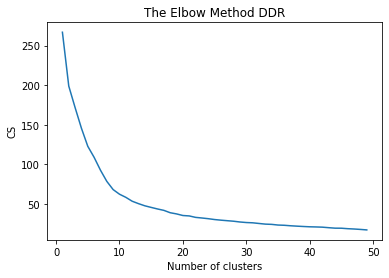

In [ ]:
df_ddr,y_ddr,X_ddr = load_data(df_ddr)
k_means_elbow_method(X_ddr,'DDR')

In [ ]:
label_ddr = k_means_clustering(8,X_ddr)
print(metrics.silhouette_score(X_ddr,label_ddr, metric='euclidean'))

78.40398876103909
0.3514450082567071


In [ ]:
df_new_ddr = make_df(label_ddr,y_ddr,'-KM.csv')

In [ ]:
print("DDR")
cm = sns.light_palette("seagreen", as_cmap=True)
df_new_ddr["cluster-label"].value_counts(dropna=False).to_frame().style.background_gradient(cmap=cm)

## Hierarchial Clustering 

In [ ]:
y = df_ddr['Unnamed: 0']
X_ddr_aglo = df_ddr.drop('Unnamed: 0',axis=1)

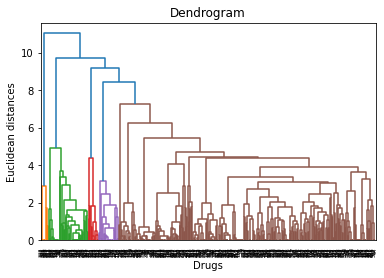

In [ ]:
import scipy.cluster.hierarchy as sch # importing scipy.cluster.hierarchy for dendrogram
dist_mat = sch.linkage(X_ddr_aglo, method = 'complete',metric='euclidean')
dendrogram = sch.dendrogram(dist_mat) # finding the optimal number of clusters using dendrogram
plt.title('Dendrogram') # title of the dendrogram
plt.xlabel('Drugs') # label of the x-axis
plt.ylabel('Euclidean distances') # label of the y-axis
plt.show() # show the dendrogram

In [ ]:
from sklearn.cluster import AgglomerativeClustering
clustering_model = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='ward')
clustering_model.fit(X_ddr_aglo)
print(metrics.silhouette_score(X_ddr_aglo,clustering_model.labels_, metric='euclidean'))

0.473135532677641


In [ ]:
df_agglo = pd.DataFrame({'node-value':y, 'cluster-label':clustering_model.labels_})
df_agglo = df_agglo.sort_values('cluster-label')
fileName = 'data/HC-128-16-final-HC.csv'
df_agglo.to_csv(fileName)

In [ ]:
cm = sns.light_palette("seagreen", as_cmap=True)
df_agglo["cluster-label"].value_counts(dropna=False).to_frame().style.background_gradient(cmap=cm)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform
import scipy
from scipy.sparse import csgraph
from numpy import linalg as LA
import scipy.cluster.hierarchy as sch
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering, AffinityPropagation
warnings.filterwarnings('ignore')

In [ ]:
def getAffinityMatrix(coordinates, k = 7):
    """
    Calculate affinity matrix based on input coordinates matrix and the numeber
    of nearest neighbours.
    
    Apply local scaling based on the k nearest neighbour
        References:
    https://papers.nips.cc/paper/2619-self-tuning-spectral-clustering.pdf
    """
    # calculate euclidian distance matrix
    dists = squareform(pdist(coordinates)) 
    
    # for each row, sort the distances ascendingly and take the index of the 
    #k-th position (nearest neighbour)
    knn_distances = np.sort(dists, axis=0)[k]
    knn_distances = knn_distances[np.newaxis].T
    
    # calculate sigma_i * sigma_j
    local_scale = knn_distances.dot(knn_distances.T)

    affinity_matrix = dists * dists
    affinity_matrix = -affinity_matrix / local_scale
    # divide square distance matrix by local scale
    affinity_matrix[np.where(np.isnan(affinity_matrix))] = 0.0
    # apply exponential
    affinity_matrix = np.exp(affinity_matrix)
    np.fill_diagonal(affinity_matrix, 0)
    return affinity_matrix

def eigenDecomposition(A, plot = True, topK = 5):
    """
    :param A: Affinity matrix
    :param plot: plots the sorted eigen values for visual inspection
    :return A tuple containing:
    - the optimal number of clusters by eigengap heuristic
    - all eigen values
    - all eigen vectors
    
    This method performs the eigen decomposition on a given affinity matrix,
    following the steps recommended in the paper:
    1. Construct the normalized affinity matrix: L = D−1/2ADˆ −1/2.
    2. Find the eigenvalues and their associated eigen vectors
    3. Identify the maximum gap which corresponds to the number of clusters
    by eigengap heuristic
    
    References:
    https://papers.nips.cc/paper/2619-self-tuning-spectral-clustering.pdf
    http://www.kyb.mpg.de/fileadmin/user_upload/files/publications/attachments/Luxburg07_tutorial_4488%5b0%5d.pdf
    """
    L = csgraph.laplacian(A, normed=True)
    n_components = A.shape[0]
    
    # LM parameter : Eigenvalues with largest magnitude (eigs, eigsh), that is, largest eigenvalues in 
    # the euclidean norm of complex numbers.
#     eigenvalues, eigenvectors = eigsh(L, k=n_components, which="LM", sigma=1.0, maxiter=5000)
    eigenvalues, eigenvectors = LA.eig(L)
    
    if plot:
        plt.title('Largest eigen values of input matrix')
        plt.scatter(np.arange(len(eigenvalues)), eigenvalues)
        plt.grid()
        
    # Identify the optimal number of clusters as the index corresponding
    # to the larger gap between eigen values
    index_largest_gap = np.argsort(np.diff(eigenvalues))[::-1][:topK]
    nb_clusters = index_largest_gap + 1
        
    return nb_clusters, eigenvalues, eigenvectors

In [ ]:
y = df_ddr['Unnamed: 0']
X_ddr_aglo = df_ddr.drop('Unnamed: 0',axis=1)

Optimal number of clusters [34 37 42 54 63]


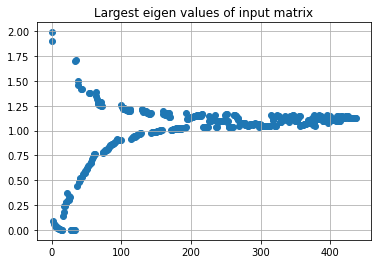

In [ ]:
affinity_matrix_moa = getAffinityMatrix(X_ddr_aglo, k = 7)
k, _,  _ = eigenDecomposition(affinity_matrix_moa)
print(f'Optimal number of clusters {k}')

In [ ]:
clustering = SpectralClustering(n_clusters=34, assign_labels="discretize", random_state=0).fit(X_ddr_aglo)
y_pred = clustering.labels_
print('silhouette_score')
print(metrics.silhouette_score(X_ddr_aglo,y_pred, metric='euclidean'))
df_new_ddr = make_df(y_pred,y,'-SC.csv')

silhouette_score
0.4615118387627958


In [ ]:
cm = sns.light_palette("seagreen", as_cmap=True)
df_new_ddr["cluster-label"].value_counts(dropna=False).to_frame().style.background_gradient(cmap=cm)